# Scatter matrix

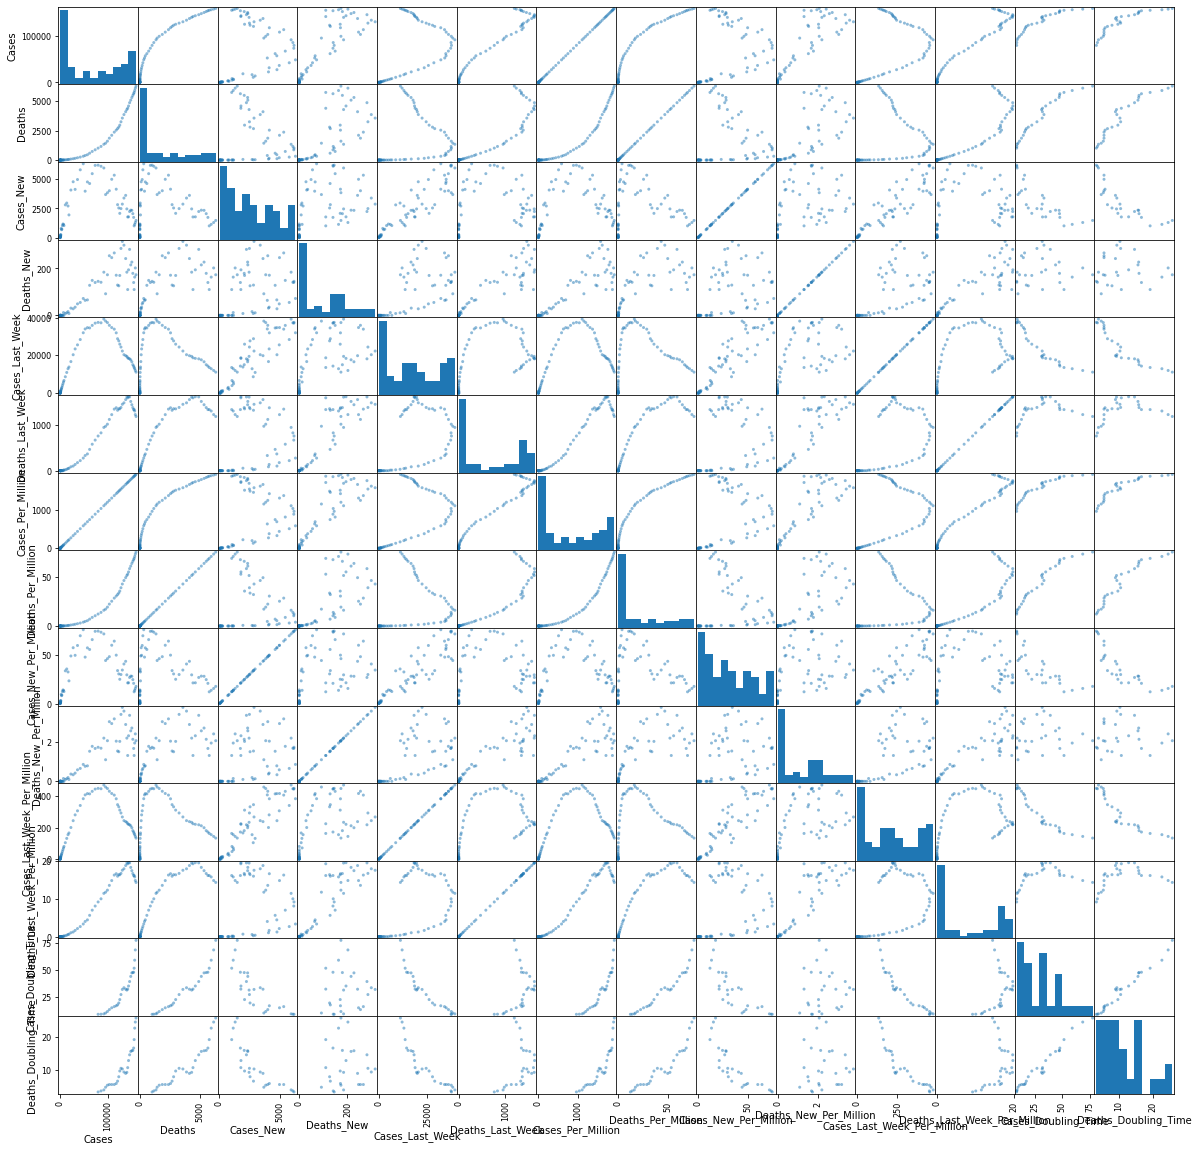

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

area = 'DE-total'
de = entorb.to_dataframe(area)
ax = pd.plotting.scatter_matrix(de, figsize=(20,20))

# R²

In [2]:
corr = de.corr()**2
corr.style.background_gradient(cmap='Blues')

,Cases,Deaths,Cases_New,Deaths_New,Cases_Last_Week,Deaths_Last_Week,Cases_Per_Million,Deaths_Per_Million,Cases_New_Per_Million,Deaths_New_Per_Million,Cases_Last_Week_Per_Million,Deaths_Last_Week_Per_Million,Cases_Doubling_Time,Deaths_Doubling_Time
Cases,1.000000,0.878090,0.101260,0.783290,0.284212,0.954828,1.000000,0.878091,0.101262,0.783269,0.284212,0.954827,0.825557,0.782275
Deaths,0.878090,1.000000,0.000577,0.574674,0.047467,0.800853,0.878090,1.000000,0.000577,0.574651,0.047467,0.800853,0.917470,0.876826
Cases_New,0.101260,0.000577,1.000000,0.197941,0.825279,0.084935,0.101260,0.000577,1.000000,0.197906,0.825279,0.084935,0.625878,0.662846
Deaths_New,0.783290,0.574674,0.197941,1.000000,0.372753,0.828834,0.783290,0.574677,0.197944,1.000000,0.372753,0.828832,0.001738,0.000292
Cases_Last_Week,0.284212,0.047467,0.825279,0.372753,1.000000,0.274537,0.284211,0.047468,0.825283,0.372740,1.000000,0.274535,0.867127,0.809505
Deaths_Last_Week,0.954828,0.800853,0.084935,0.828834,0.274537,1.000000,0.954828,0.800854,0.084937,0.828832,0.274538,1.000000,0.166200,0.123103
Cases_Per_Million,1.000000,0.878090,0.101260,0.783290,0.284211,0.954828,1.000000,0.878091,0.101262,0.783269,0.284212,0.954827,0.825557,0.782275
Deaths_Per_Million,0.878091,1.000000,0.000577,0.574677,0.047468,0.800854,0.878091,1.000000,0.000577,0.574654,0.047468,0.800854,0.917471,0.876826
Cases_New_Per_Million,0.101262,0.000577,1.000000,0.197944,0.825283,0.084937,0.101262,0.000577,1.000000,0.197908,0.825283,0.084937,0.625882,0.662849
Deaths_New_Per_Million,0.783269,0.574651,0.197906,1.000000,0.372740,0.828832,0.783269,0.574654,0.197908,1.000000,0.372740,0.828830,0.001732,0.000295


# Deaths formula:

Deaths(Cases) = 
               4                 3                2
5.612e-18 Cases + 1.287e-14 Cases + 9.19e-08 Cases + 0.001988 Cases - 5.195


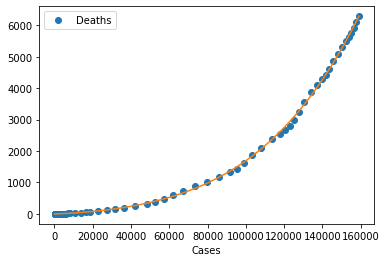

In [3]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=4)
de.plot(kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
plt.plot(de['Cases'], poly(de['Cases']))
print("Deaths(Cases) = ")
print(poly)

-12.581105578512561

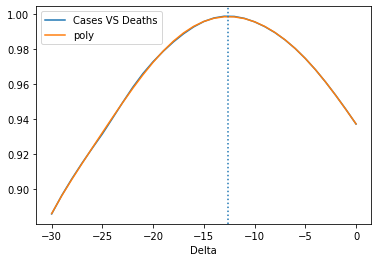

In [4]:
overlapping_days = int(0.5 * min([len(de['Cases']), len(de['Deaths'])]))

lcor = lagged_correlation = pd.DataFrame.from_dict(
    {'Cases VS Deaths': [de['Cases'].corr(de['Deaths'].shift(-t)) for t in range(overlapping_days)],
     'Delta': [-t for t in range(overlapping_days)]}).set_index('Delta')

ax = lcor.plot()
lcor.idxmax()
poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases VS Deaths'], deg=7), variable='r')
plt.plot(lcor.index, poly(lcor.index), label="poly")
lag = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][0]
ax.axvline(lag, linestyle=':')
ax.legend()
display(lag)